# Day 3, Practical 3

In this exercise we will cover:
 - Generating and displaying pairwise $F_{st}$ values
 - An example of f4 / D-statistics 
    
    
Tools used: plink2, R

The notebooks are editable, so feel free to experiment and change the code to see what happens or write notes in the text cells. Just remember to download the notebooks used here at some point if you want to save them with your own changes included.

In [1]:
### make directory for the exercise
mkdir -p ~/kenya2024/Fstats
cd ~/kenya2024/Fstats

which plink2
which R

/usr/bin/plink2
/usr/bin/R


We will be using the data set of called genotypes from different blue wildebeest populations, as well as some black wildebeest as an outgroup to compare to, saved in a plink format file set. 

Here is the map from earlier to help show the sampling locations of the different blue wildebeest populations:
<img src="https://raw.githubusercontent.com/popgenDK/popgenDK.github.io/gh-pages/images/slider/wildeBeastMap.png" alt="image info" />


 - Do you remember what a plink file set (.bed, bim and .fam) contains?
 

In [2]:
head /davidData/users/thomas/workshop/wildebeest_fst.fam

CGnoNa_58015 CGnoNa_58015 0 0 0 -9
CGnoNa_58017 CGnoNa_58017 0 0 0 -9
CGnoNaC_1324 CGnoNaC_1324 0 0 0 -9
CGnoNaC_1329 CGnoNaC_1329 0 0 0 -9
CGnoNaC_1356 CGnoNaC_1356 0 0 0 -9
CGnoNaC_2627 CGnoNaC_2627 0 0 0 -9
CGnoNaC_2628 CGnoNaC_2628 0 0 0 -9
CGnoNaC_2630 CGnoNaC_2630 0 0 0 -9
CGnoNaC_2632 CGnoNaC_2632 0 0 0 -9
CGnoNaC_2633 CGnoNaC_2633 0 0 0 -9


In [3]:
head /davidData/users/thomas/workshop/wildebeest_fst.bim

HiC_scaffold_1	HiC_scaffold_1:24234:A:.	0	24234	G	A
HiC_scaffold_1	HiC_scaffold_1:24262:T:C	0	24262	C	T
HiC_scaffold_1	HiC_scaffold_1:24269:C:.	0	24269	G	C
HiC_scaffold_1	HiC_scaffold_1:24329:G:.	0	24329	A	G
HiC_scaffold_1	HiC_scaffold_1:24346:A:.	0	24346	C	A
HiC_scaffold_1	HiC_scaffold_1:24445:T:.	0	24445	C	T
HiC_scaffold_1	HiC_scaffold_1:24467:C:.	0	24467	T	C
HiC_scaffold_1	HiC_scaffold_1:24476:G:.	0	24476	A	G
HiC_scaffold_1	HiC_scaffold_1:24543:T:.	0	24543	C	T
HiC_scaffold_1	HiC_scaffold_1:24561:C:.	0	24561	T	C


Below we have the command used to run the $F_{st}$ estimation:

In [4]:
plink2 --bfile /davidData/users/thomas/workshop/wildebeest_fst --within /davidData/users/thomas/workshop/clusterfile \
    --fst CATPHENO method=hudson --allow-extra-chr --threads 10

PLINK v2.00a6LM AVX2 Intel (6 Aug 2024)        www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink2.log.
Options in effect:
  --allow-extra-chr
  --bfile /davidData/users/thomas/workshop/wildebeest_fst
  --fst CATPHENO method=hudson
  --threads 10
  --within /davidData/users/thomas/workshop/clusterfile

Start time: Thu Aug  8 14:27:21 2024
386829 MiB RAM detected, ~331014 available; reserving 193414 MiB for main
workspace.
Using up to 10 threads (change this with --threads).
95 samples (0 females, 0 males, 95 ambiguous; 95 founders) loaded from
/davidData/users/thomas/workshop/wildebeest_fst.fam.
Note: 28 nonstandard chromosome codes present.
43047242 variants loaded from
/davidData/users/thomas/workshop/wildebeest_fst.bim.
--within: 9 non-null categories present.
1 categorical phenotype loaded (95 values).
--fst: Analyzing 95 samples across 9 populations.
Autosomal --fst: 10111213141516171819202122232425262728

 - The cluster/within file used here tells the program how to separate the individuals into different groups for comparison. If we did not know up front which samples belonged together in populations, can you recall something we have looked at that could perhaps help with this?

Then let's have a look at the results:

In [5]:
# some hartebeest samples were also originally included in this data set, but now we can just remove those from
# the output
grep -ve Hartebeest plink2.fst.summary > tmp
mv tmp plink2.fst.summary

# print the results
column -t plink2.fst.summary

#POP1     POP2       HUDSON_FST
Amboseli  Black      0.531708
Amboseli  Ethosha    0.224743
Amboseli  Luangwa    0.301884
Amboseli  Monduli    0.110156
Amboseli  Nairobi    0.000902228
Amboseli  Selous     0.295483
Amboseli  Serengeti  0.170069
Black     Ethosha    0.443276
Black     Luangwa    0.536717
Black     Monduli    0.481127
Black     Nairobi    0.526759
Black     Selous     0.539495
Black     Serengeti  0.490266
Ethosha   Luangwa    0.193734
Ethosha   Monduli    0.147586
Ethosha   Nairobi    0.217494
Ethosha   Selous     0.19825
Ethosha   Serengeti  0.164245
Luangwa   Monduli    0.220976
Luangwa   Nairobi    0.293731
Luangwa   Selous     0.195965
Luangwa   Serengeti  0.24107
Monduli   Nairobi    0.101553
Monduli   Selous     0.21675
Monduli   Serengeti  0.0246107
Nairobi   Selous     0.287543
Nairobi   Serengeti  0.161879
Selous    Serengeti  0.240375


 - Which populations are most genetically differentiated? Which are most similar?
 
 - Can you indentify a pattern in the Fst values between black wildebeest and each of the blue wildebeest populations? Try to see if you can explain this pattern.

Are each of these values large or small? This is quite difficult to answer without context, as it will depend on the type of data you are analyzing, the amount of data and the scope of your study. To provide context, one often looks at a matrix of $F_{st}$ values, which can be visualized using a heatmap. To do this we first need to transform the above data frame into a matrix, and then generate a heatmap using the heatmap.2-function.

In [6]:
options(repr.matrix.max.cols=10, repr.matrix.max.rows=10)
options(repr.plot.width=16, repr.plot.height=16)

# read the data into R
fst <- read.table("~/kenya2024/Fstats/plink2.fst.summary")
names(fst) <- c("pop1", "pop2", "est")
fst <- fst[fst$pop1 != "Hartebeest" & fst$pop2 != "Hartebeest",]

Here we transform the table from above into a pairwise matrix that contains the exact same information, just in a different format:

In [7]:
mat <- matrix(NA, 8, 8)
mat[lower.tri(mat)] <- fst$est
mat <- t(mat)
mat[lower.tri(mat)] <- fst$est
colnames(mat) <- c( "Amboseli", fst[1:7,2])
rownames(mat) <- c( "Amboseli", fst[1:7,2])
mat

,Amboseli,Black,Ethosha,Luangwa,Monduli,Nairobi,Selous,Serengeti
Amboseli,NA,0.531708,0.224743,0.301884,0.1101560,0.000902228,0.295483,0.1700690
Black,0.531708000,NA,0.443276,0.536717,0.4811270,0.526759000,0.539495,0.4902660
Ethosha,0.224743000,0.443276,NA,0.193734,0.1475860,0.217494000,0.198250,0.1642450
Luangwa,0.301884000,0.536717,0.193734,NA,0.2209760,0.293731000,0.195965,0.2410700
Monduli,0.110156000,0.481127,0.147586,0.220976,NA,0.101553000,0.216750,0.0246107
Nairobi,0.000902228,0.526759,0.217494,0.293731,0.1015530,NA,0.287543,0.1618790
Selous,0.295483000,0.539495,0.198250,0.195965,0.2167500,0.287543000,NA,0.2403750
Serengeti,0.170069000,0.490266,0.164245,0.241070,0.0246107,0.161879000,0.240375,NA


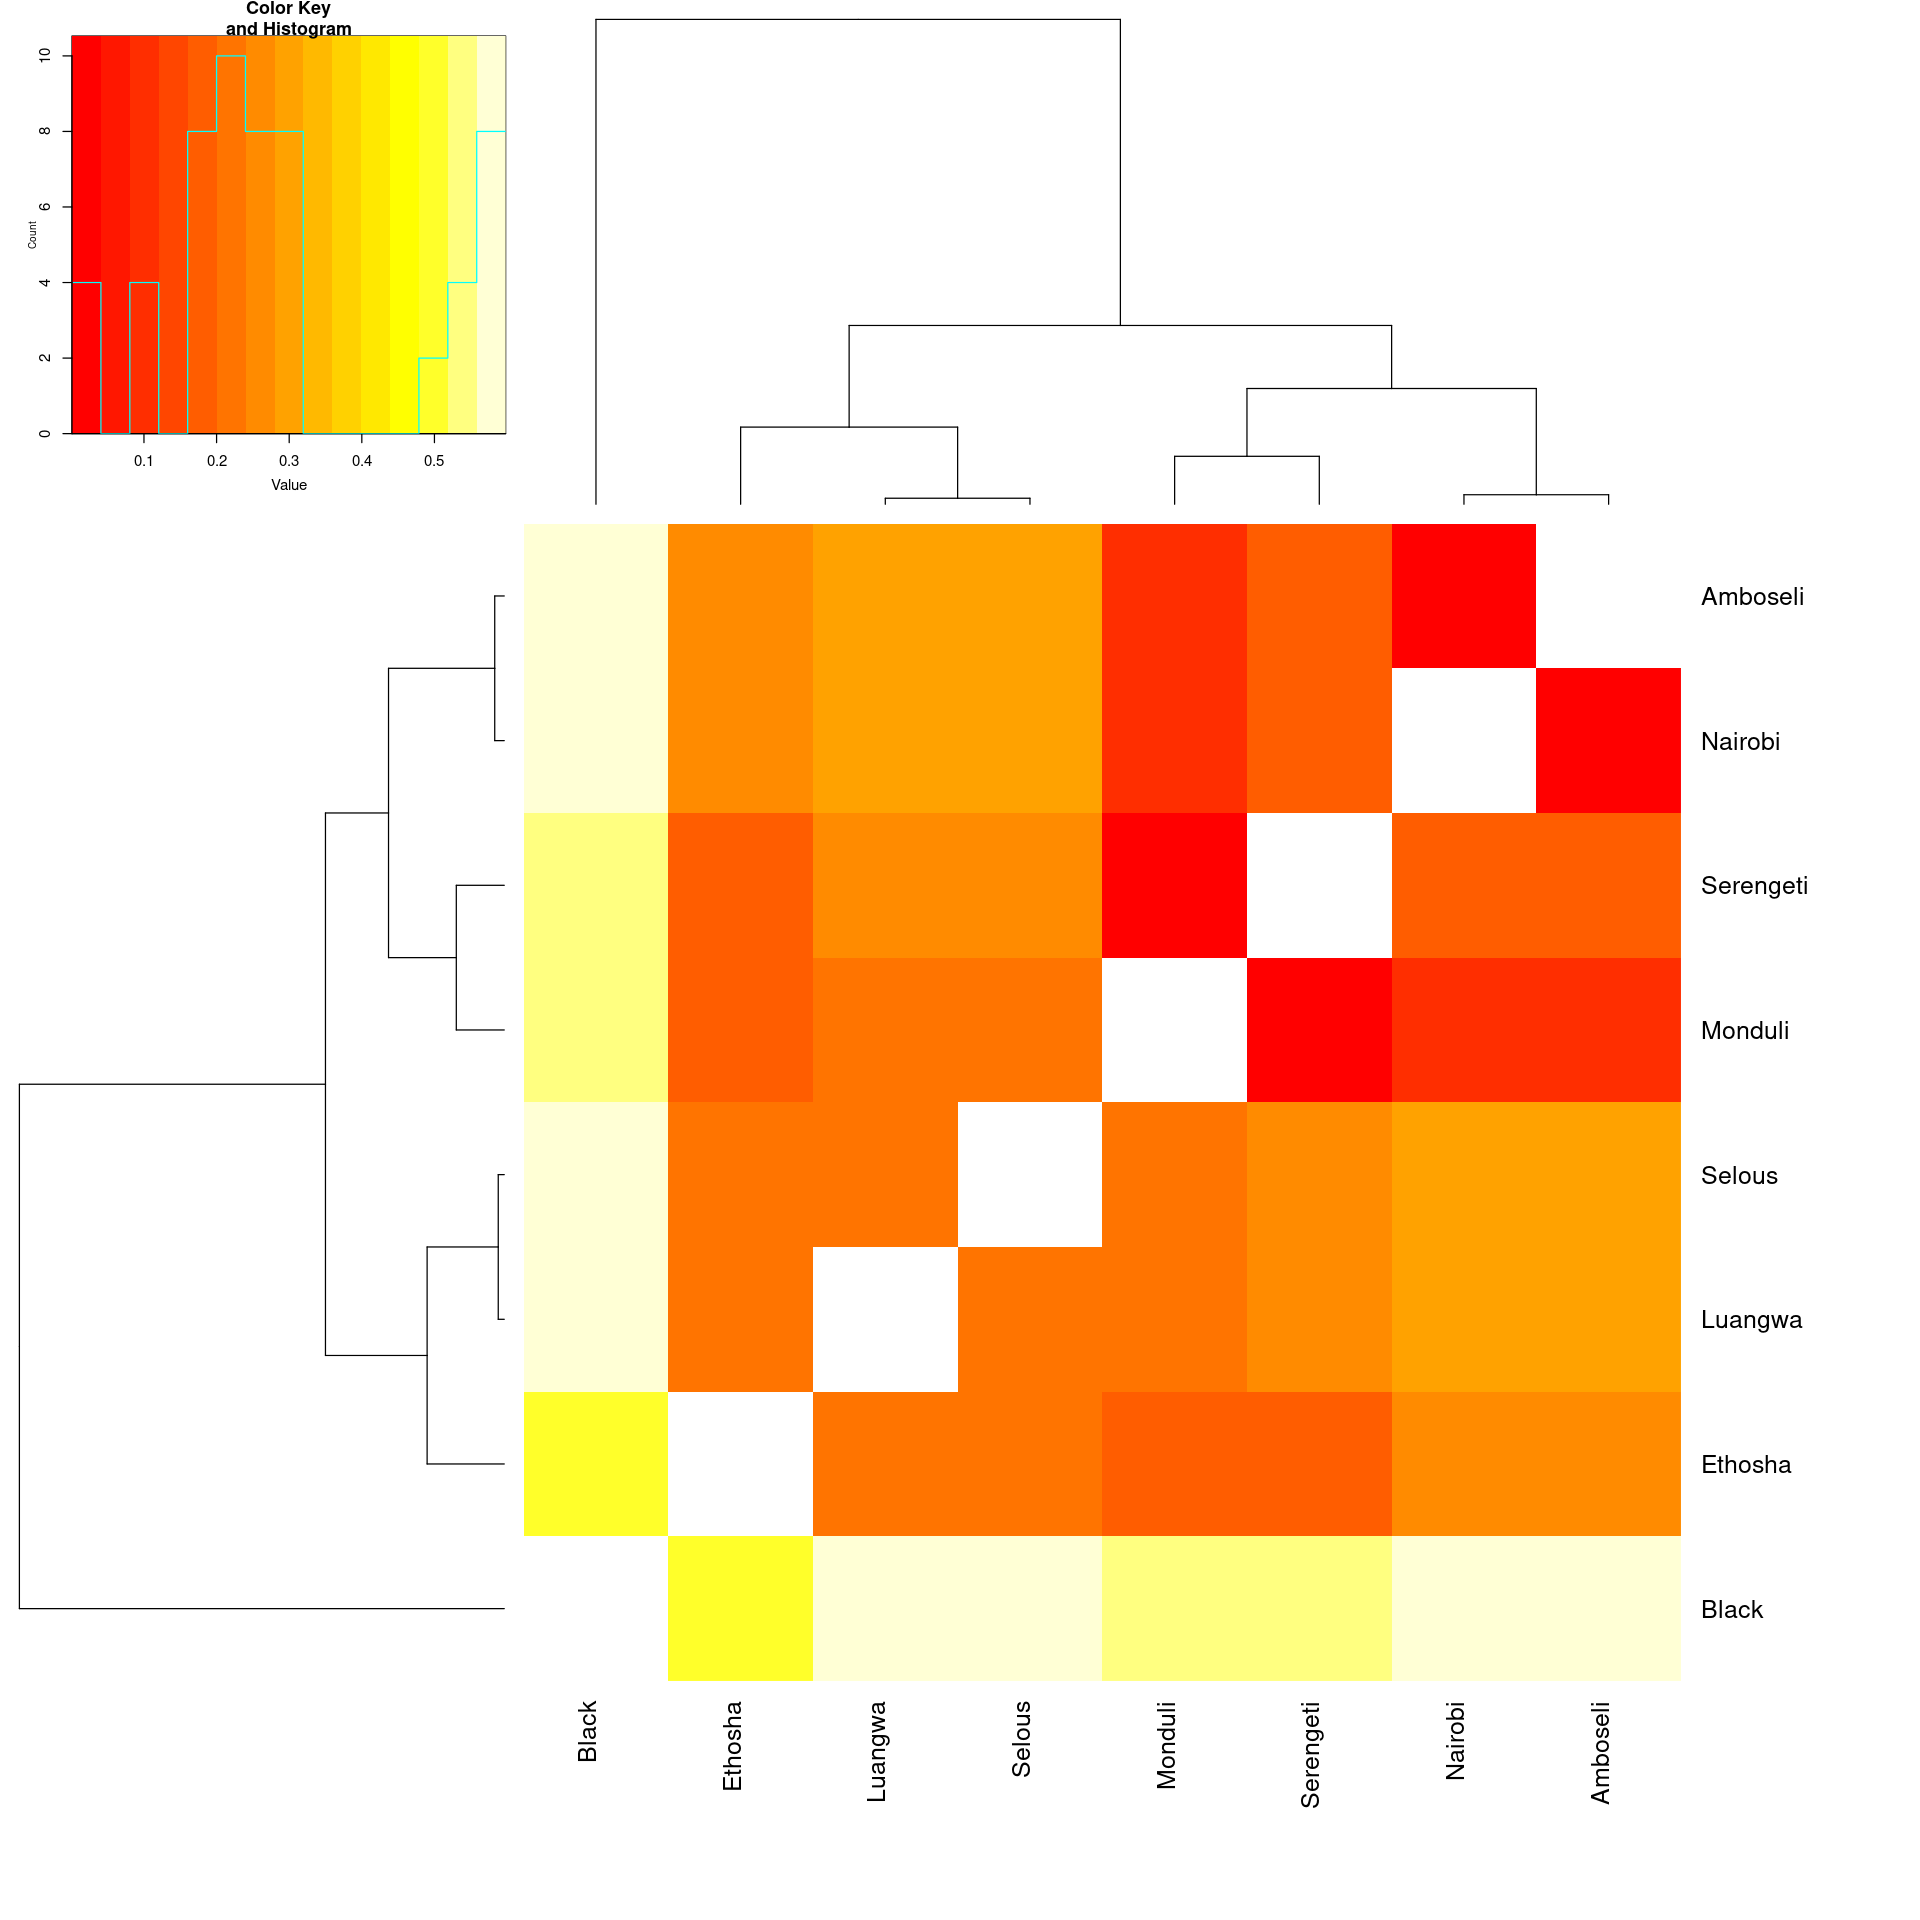

In [24]:
heatmap.2(mat, symm=T, trace='n', scale = 'n', cexRow=1.5, cexCol=1.5, margins = c(12, 12))

 - Look at the clustering tree produced by this method. Do the different groups relate to each other as we would expect?

- We can see some discrete levels of values in the color key and in the histogram in the inset plot. What do these correspond to?
 
An important note here is that the tree/dendrogram used to order the groups here simply comes from clustering based on the $F_{st}$ values and will not neccesarily reflect the true evolutionary history of the groups.



## F4 / D-statistic
For this part of the exercise we can use the R package admixtools to compute F4 values which correspond to the D-statistic mentioned earlier in the day, just with a flipped sign, so that negative values of F4 correspond to a positive D-statistic and vice versa.

Here we take a look at whether any of the populations of blue wildebeest are more closely related to the black wildebeest than the others - which indicates gene flow.

In [8]:
library(admixtools)
library(tidyverse)
options(repr.plot.width=16)

# load in f2 values that were pre computed from the plink data set
f2 <- read_f2("/davidData/users/thomas/workshop/wildebeest_fstats_wildebeestref")

# define tree of relationships between groups, this format is a bit hard to read,
#  but is similar to newick format for those familiar

tree <- c(c(c(c(c(c('N-Selous', 'C-Luangwa'), 'B-Ethosha'), c(c(c("E-Nairobi", "E-Amboseli"), "E-Monduli"), 'W-Serengeti')), 'black'), "hartebeest"))

# generate f4 values
f4 <- f4(f2, tree, f4mode = FALSE)

# select only values for subtrees where pop3 is black wildebeest and outgroup is hartebeest
f4_sub <- f4[f4$pop4=="hartebeest" & f4$pop3=="black",]

# make new row for each combination of pop 1 and pop 2 where they are switched and their f4 flipped, to make plot look nicer
f4_sub_switched <- f4_sub %>%
                          mutate(
                            temp = .data[["pop1"]],
                            !!"pop1" := .data[["pop2"]],
                            !!"pop2" := temp,
                            across(all_of(c("est", "z" )), ~ . * -1)
                          ) %>%
                          select(-temp)

f4_sub <- bind_rows(f4_sub, f4_sub_switched)

# show resulting subset
f4_sub

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


pop1,pop2,pop3,pop4,est,se,z,p
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
N-Selous,C-Luangwa,black,hartebeest,-1.071328e-04,3.295432e-05,-3.250949,0.001150205
N-Selous,B-Ethosha,black,hartebeest,-2.035461e-03,4.347068e-05,-46.823765,0.000000000
N-Selous,E-Nairobi,black,hartebeest,6.418209e-05,4.010064e-05,1.600525,0.109482146
N-Selous,E-Amboseli,black,hartebeest,9.648712e-05,3.816031e-05,2.528468,0.011456165
N-Selous,E-Monduli,black,hartebeest,4.689301e-05,3.729037e-05,1.257510,0.208569001
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
E-Monduli,E-Nairobi,black,hartebeest,1.728907e-05,2.453836e-05,0.7045733,0.481075823
W-Serengeti,E-Nairobi,black,hartebeest,4.739073e-05,2.930377e-05,1.6172228,0.105830187
E-Monduli,E-Amboseli,black,hartebeest,4.959411e-05,2.153984e-05,2.3024365,0.021310570


In this output, look for values in the column labelled 'z'. Those rows that have values higher than 3 or lower than -3 are usually considered statistically significant. If the value is negative, it means that the population in column pop2 has more alleles in common with black wildebeest than the population in column pop1. If it's positive, the interpretation is the opposite, i.e. pop1 has more alleles in common with black than pop2.

This can also be shown in a plot. Run this plotting code and see if you can make sense of the plot below.

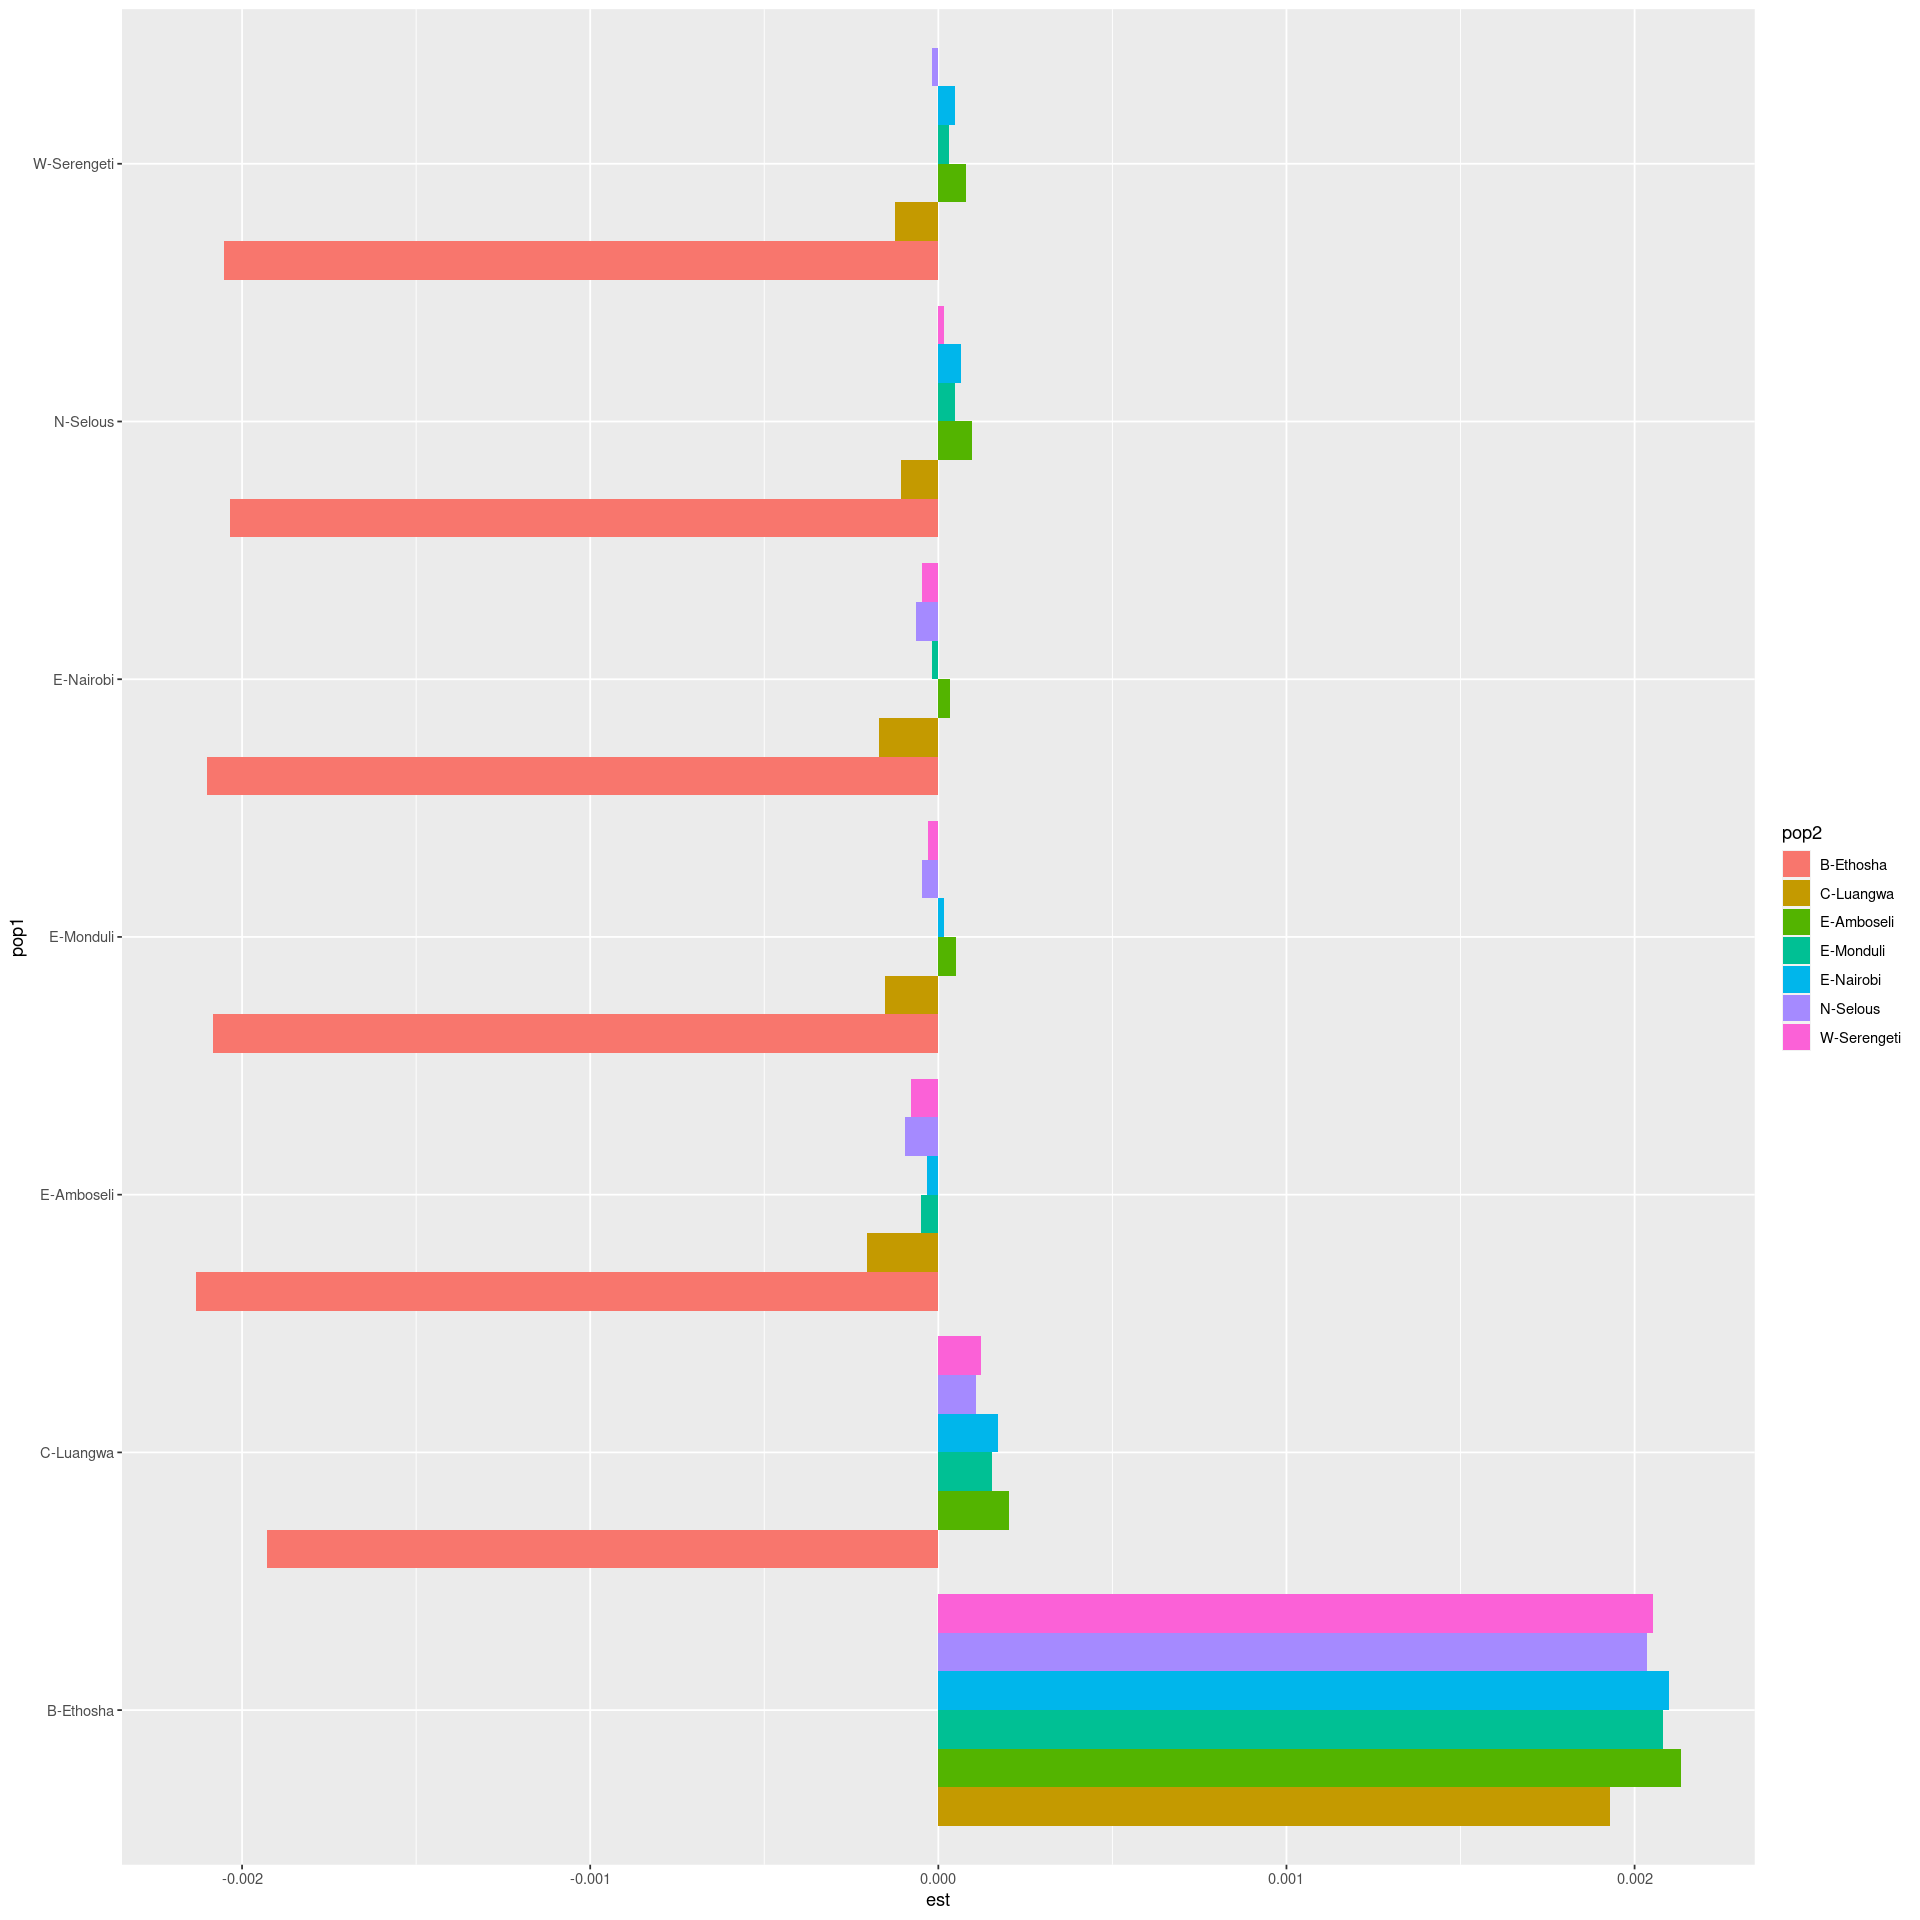

In [9]:
ggplot(f4_sub, aes(est, pop1, fill = pop2)) +
geom_bar(stat = "identity", position = "dodge")

 - Which population of blue wildebeest had gene flow with black wildebeest? How do you think this happened, and why is it not all blue wildebeests that had gene flow with black wildebeest?